In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt

2023-11-28 22:10:49.452912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 22:10:49.452978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 22:10:49.453011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 22:10:49.459679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:1

# Dataset

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

batch_size = 32
img_height = 96
img_width = 96

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-11-28 22:10:54.929581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 22:10:54.937416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 22:10:54.937714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Normal model

In [5]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(len(class_names), activation="linear"),
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
92/92 [==============================] - 2s 11ms/step - loss: 1.4336 - accuracy: 0.3713 - val_loss: 1.2908 - val_accuracy: 0.4401
Epoch 2/20
92/92 [==============================] - 1s 9ms/step - loss: 1.1833 - accuracy: 0.5150 - val_loss: 1.1631 - val_accuracy: 0.5163
Epoch 3/20
92/92 [==============================] - 1s 9ms/step - loss: 1.0133 - accuracy: 0.6005 - val_loss: 1.0303 - val_accuracy: 0.5654
Epoch 4/20
92/92 [==============================] - 1s 9ms/step - loss: 0.9362 - accuracy: 0.6366 - val_loss: 0.9604 - val_accuracy: 0.6117
Epoch 5/20
92/92 [==============================] - 1s 9ms/step - loss: 0.8645 - accuracy: 0.6747 - val_loss: 0.9602 - val_accuracy: 0.5940
Epoch 6/20
92/92 [==============================] - 1s 9ms/step - loss: 0.7933 - accuracy: 0.7027 - val_loss: 0.9373 - val_accuracy: 0.6090
Epoch 7/20
92/92 [==============================] - 1s 9ms/step - loss: 0.7436 - accuracy: 0.7228 - val_loss: 0.9763 - val_accuracy: 0.5995
Epoch 8/20
92/92 [=

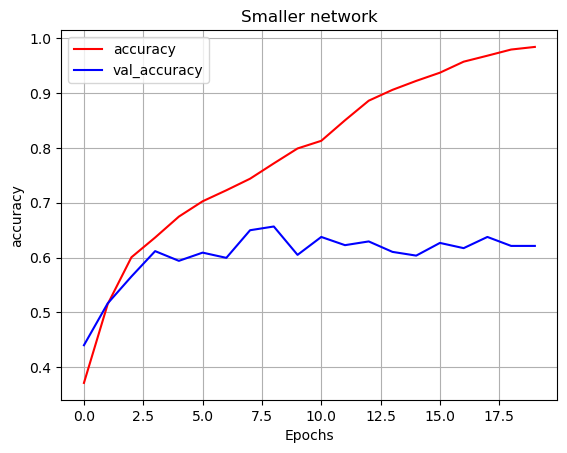

In [6]:
plt.figure()

plt.plot(history.history['accuracy'], label='accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')

plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title("Smaller network")

plt.legend()
plt.grid(True)
plt.show()

## Augmented data model

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

model_with_aug = tf.keras.Sequential(
    [
        data_augmentation,
        tf.keras.layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(len(class_names), activation="linear"),
    ]
)

model_with_aug.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history_with_aug = model_with_aug.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
92/92 [==============================] - 3s 11ms/step - loss: 1.4640 - accuracy: 0.3546 - val_loss: 1.1928 - val_accuracy: 0.5204
Epoch 2/20
92/92 [==============================] - 1s 10ms/step - loss: 1.1246 - accuracy: 0.5511 - val_loss: 1.0576 - val_accuracy: 0.5763
Epoch 3/20
92/92 [==============================] - 1s 9ms/step - loss: 1.0236 - accuracy: 0.5988 - val_loss: 1.0233 - val_accuracy: 0.5872
Epoch 4/20
92/92 [==============================] - 1s 9ms/step - loss: 0.9902 - accuracy: 0.6216 - val_loss: 1.0252 - val_accuracy: 0.6063
Epoch 5/20
92/92 [==============================] - 1s 10ms/step - loss: 0.9561 - accuracy: 0.6294 - val_loss: 1.0791 - val_accuracy: 0.5804
Epoch 6/20
92/92 [==============================] - 1s 9ms/step - loss: 0.8993 - accuracy: 0.6536 - val_loss: 1.0887 - val_accuracy: 0.6008
Epoch 7/20
92/92 [==============================] - 1s 10ms/step - loss: 0.8960 - accuracy: 0.6604 - val_loss: 1.4907 - val_accuracy: 0.5245
Epoch 8/20
92/92

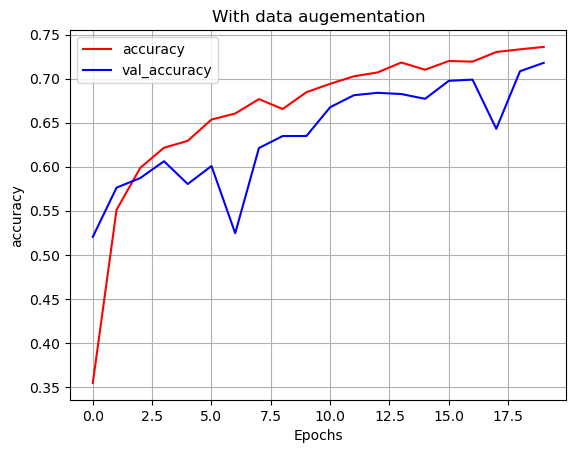

In [10]:
plt.figure()

plt.plot(history_with_aug.history['accuracy'], label='accuracy', color='red')
plt.plot(history_with_aug.history['val_accuracy'], label='val_accuracy', color='blue')

plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title("With data augementation")

plt.legend()
plt.grid(True)
plt.show()

## Dropout model

In [11]:
dropout_model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(len(class_names), activation="linear"),
    ]
)

dropout_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

dropout_history = dropout_model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20


2023-11-28 22:30:00.707090: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 [==============================] - 3s 11ms/step - loss: 1.3446 - accuracy: 0.4087 - val_loss: 1.1230 - val_accuracy: 0.5232
Epoch 2/20
92/92 [==============================] - 1s 10ms/step - loss: 1.0693 - accuracy: 0.5661 - val_loss: 1.0708 - val_accuracy: 0.5341
Epoch 3/20
92/92 [==============================] - 1s 9ms/step - loss: 0.9606 - accuracy: 0.6267 - val_loss: 0.9720 - val_accuracy: 0.5981
Epoch 4/20
92/92 [==============================] - 1s 9ms/step - loss: 0.8749 - accuracy: 0.6706 - val_loss: 0.9506 - val_accuracy: 0.6185
Epoch 5/20
92/92 [==============================] - 1s 9ms/step - loss: 0.7958 - accuracy: 0.6938 - val_loss: 0.9559 - val_accuracy: 0.6253
Epoch 6/20
92/92 [==============================] - 1s 10ms/step - loss: 0.7243 - accuracy: 0.7268 - val_loss: 0.9464 - val_accuracy: 0.6199
Epoch 7/20
92/92 [==============================] - 1s 9ms/step - loss: 0.6648 - accuracy: 0.7446 - val_loss: 0.8892 - val_accuracy: 0.6458
Epoch 8/20
92/92 [==========

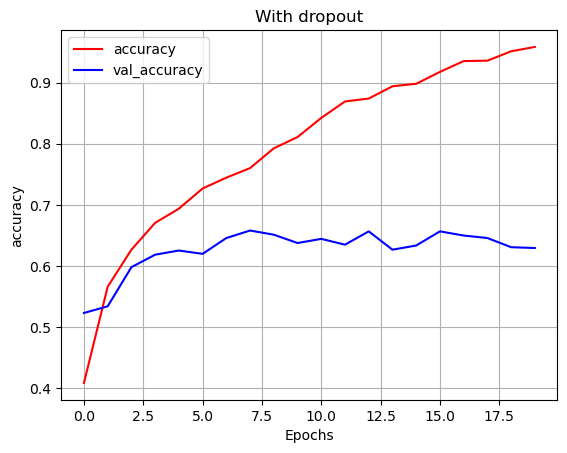

In [17]:
plt.figure()

plt.plot(dropout_history.history['accuracy'], label='accuracy', color='red')
plt.plot(dropout_history.history['val_accuracy'], label='val_accuracy', color='blue')

plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title("With dropout")

plt.legend()
plt.grid(True)
plt.show()

## Model with ELU

In [13]:
model_with_elu = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        tf.keras.layers.Conv2D(8, 3, padding="same", activation="elu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="elu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="elu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation="elu"),
        tf.keras.layers.Dense(len(class_names), activation="linear"),
    ]
)

model_with_elu.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history_with_elu = model_with_elu.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
92/92 [==============================] - 2s 12ms/step - loss: 1.3178 - accuracy: 0.4601 - val_loss: 1.2951 - val_accuracy: 0.4169
Epoch 2/20
92/92 [==============================] - 1s 9ms/step - loss: 1.0542 - accuracy: 0.5821 - val_loss: 1.0476 - val_accuracy: 0.5913
Epoch 3/20
92/92 [==============================] - 1s 10ms/step - loss: 0.9355 - accuracy: 0.6475 - val_loss: 0.9725 - val_accuracy: 0.6063
Epoch 4/20
92/92 [==============================] - 1s 10ms/step - loss: 0.8021 - accuracy: 0.6931 - val_loss: 0.9648 - val_accuracy: 0.6281
Epoch 5/20
92/92 [==============================] - 1s 9ms/step - loss: 0.7019 - accuracy: 0.7520 - val_loss: 0.9648 - val_accuracy: 0.6335
Epoch 6/20
92/92 [==============================] - 1s 10ms/step - loss: 0.5757 - accuracy: 0.7943 - val_loss: 1.0371 - val_accuracy: 0.6281
Epoch 7/20
92/92 [==============================] - 1s 10ms/step - loss: 0.4713 - accuracy: 0.8413 - val_loss: 1.1116 - val_accuracy: 0.6131
Epoch 8/20
92/9

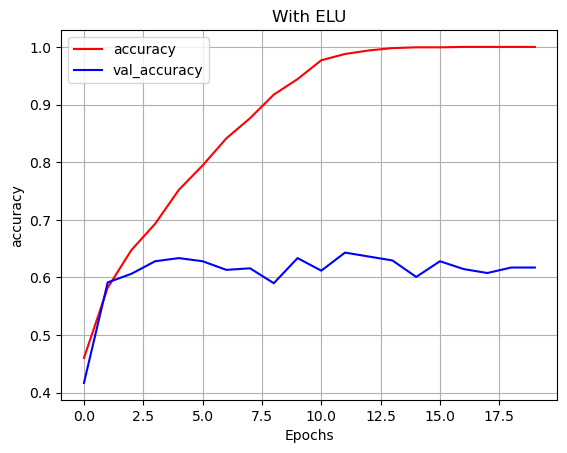

In [15]:
plt.figure()

plt.plot(history_with_elu.history['accuracy'], label='accuracy', color='red')
plt.plot(history_with_elu.history['val_accuracy'], label='val_accuracy', color='blue')

plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title("With ELU")

plt.legend()
plt.grid(True)
plt.show()

## Model with batch normalization

In [14]:
model_with_bnorm = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(len(class_names), activation="linear"),
    ]
)

model_with_bnorm.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history_with_bnorm = model_with_bnorm.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
92/92 [==============================] - 3s 12ms/step - loss: 1.3330 - accuracy: 0.4649 - val_loss: 3.1860 - val_accuracy: 0.2916
Epoch 2/20
92/92 [==============================] - 1s 10ms/step - loss: 0.9534 - accuracy: 0.6076 - val_loss: 2.7957 - val_accuracy: 0.3311
Epoch 3/20
92/92 [==============================] - 1s 10ms/step - loss: 0.7687 - accuracy: 0.6948 - val_loss: 2.3257 - val_accuracy: 0.3338
Epoch 4/20
92/92 [==============================] - 1s 10ms/step - loss: 0.5828 - accuracy: 0.7636 - val_loss: 1.8017 - val_accuracy: 0.4332
Epoch 5/20
92/92 [==============================] - 1s 10ms/step - loss: 0.4409 - accuracy: 0.8263 - val_loss: 1.6045 - val_accuracy: 0.4550
Epoch 6/20
92/92 [==============================] - 1s 10ms/step - loss: 0.3070 - accuracy: 0.8873 - val_loss: 1.3762 - val_accuracy: 0.5599
Epoch 7/20
92/92 [==============================] - 1s 10ms/step - loss: 0.2096 - accuracy: 0.9336 - val_loss: 1.4681 - val_accuracy: 0.5804
Epoch 8/20
92

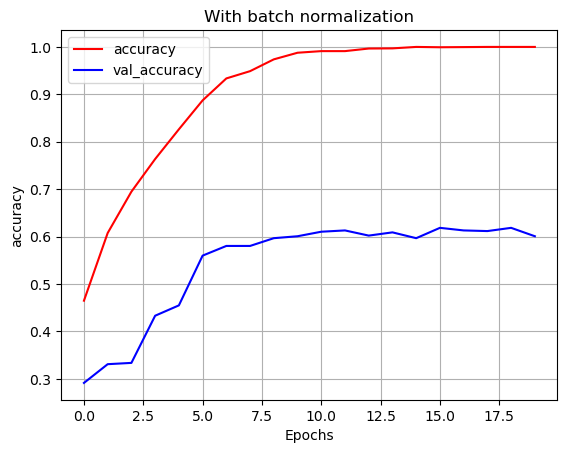

In [16]:
plt.figure()

plt.plot(history_with_bnorm.history['accuracy'], label='accuracy', color='red')
plt.plot(history_with_bnorm.history['val_accuracy'], label='val_accuracy', color='blue')

plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title("With batch normalization")

plt.legend()
plt.grid(True)
plt.show()